In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Q1
## Use of PERMNO vs. TICKERS:

PERMNO is a unique identifier assigned by the Center for Research in Security Prices (CRSP) to each security in the market. It is a consistent way to track securities over time, regardless of changes in ticker symbols, company names, or corporate actions such as mergers and acquisitions. This consistency is important for analysis over long periods, as it allows for the unambiguous identification of securities.


TICKERS are symbols assigned to securities traded on public exchanges. These can change over time due to various reasons, such as rebranding, mergers, or moving between exchanges, which can create confusion in long-term analysis.

# Q2
## Discrepancies between One-Month Price Change and PRC Column:

a. This discrepancy is not data error. The PRC column reflects the total return, and it includes the price appreciation/depreciation, dividends, and other distributions paid to investors. Total return is a comprehensive view of a stock's performance.

The percent changes of price simply reflects the movement in the security's market price. This calculation does not account for dividends or other returns of holding the security. It only focuses on price appreciation/depreciation.

b. For some companies, these values may always match. Because there are no dividends or distributions, or any other corporate actions that might affect the total return.

In [3]:
# Price_Ret(T1)

file_path = 'sp500raw.xlsx'
sp500_data = pd.read_excel(file_path)
sp500_data.drop(columns=['Unnamed: 0'], inplace =True)
sp500_data['date'] = pd.to_datetime(sp500_data['date'])
sp500_data.sort_values(by=['permno', 'date'], inplace=True)

sp500_data['Price_Ret(T1)'] = sp500_data.groupby('permno')['price'].pct_change()


display(sp500_data.head())


,permno,date,price,shrout,prc,mcap,Price_Ret(T1)
48,10104,2011-01-31,32.0300,5052420,0.024920,1.618290e+08,NaN
719,10104,2011-02-28,32.9000,5061000,0.027162,1.665069e+08,0.027162
1100,10104,2011-03-31,33.4325,5060516,0.016185,1.691857e+08,0.016185
1836,10104,2011-04-29,35.9600,5060516,0.077395,1.819762e+08,0.075600
2410,10104,2011-05-31,34.2200,5068000,-0.048387,1.734270e+08,-0.048387


# Q3
## Variability in the Number of Companies:

The number of companies in the S&P 500 index does not always precisely equal 500 due to several factors, including mergers, acquisitions, bankruptcies, and the addition or removal of companies based on the market capitalization criteria set by the index. These events can cause the number of constituents to fluctuate over time. So it's not a mistake. It reflects the dynamic nature of the stock market and the index's composition adjustments to maintain its representation of the U.S. economy's leading companies.

# Q4

## 303 companies are present over the entire sample 
## 761 unique companies are in the sample

In [4]:
date_counts = sp500_data.groupby('permno').size()
full_presence_companies = date_counts[date_counts == sp500_data['date'].nunique()]

unique_companies = sp500_data['permno'].nunique()

(full_presence_companies.count(), unique_companies)

(303, 761)

# Q5



First, we plot the time series of market cap for all stocks each month

<Axes: title={'center': 'Different percentile for market cap'}, xlabel='date', ylabel='mcap'>

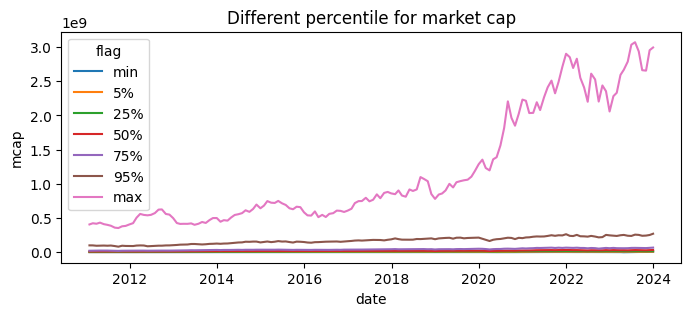

In [5]:
mcap_plot = sp500_data.groupby('date')['mcap'].describe(percentiles=[0.05,0.25,0.75,0.95]).reset_index()

col_plot = ['min', '5%', '25%', '50%', '75%', '95%','max']
df_list = []
for i in col_plot:
    tmp_df = mcap_plot[['date',i]]
    tmp_df['flag'] = i
    tmp_df.rename(columns={i:'mcap'},inplace=True)
    df_list.append(tmp_df)
mcap_final = pd.concat(df_list,axis=0)

plt.figure(figsize=(8,3))
plt.title('Different percentile for market cap')
sns.lineplot(data=mcap_final,x = 'date',y = 'mcap',hue='flag')


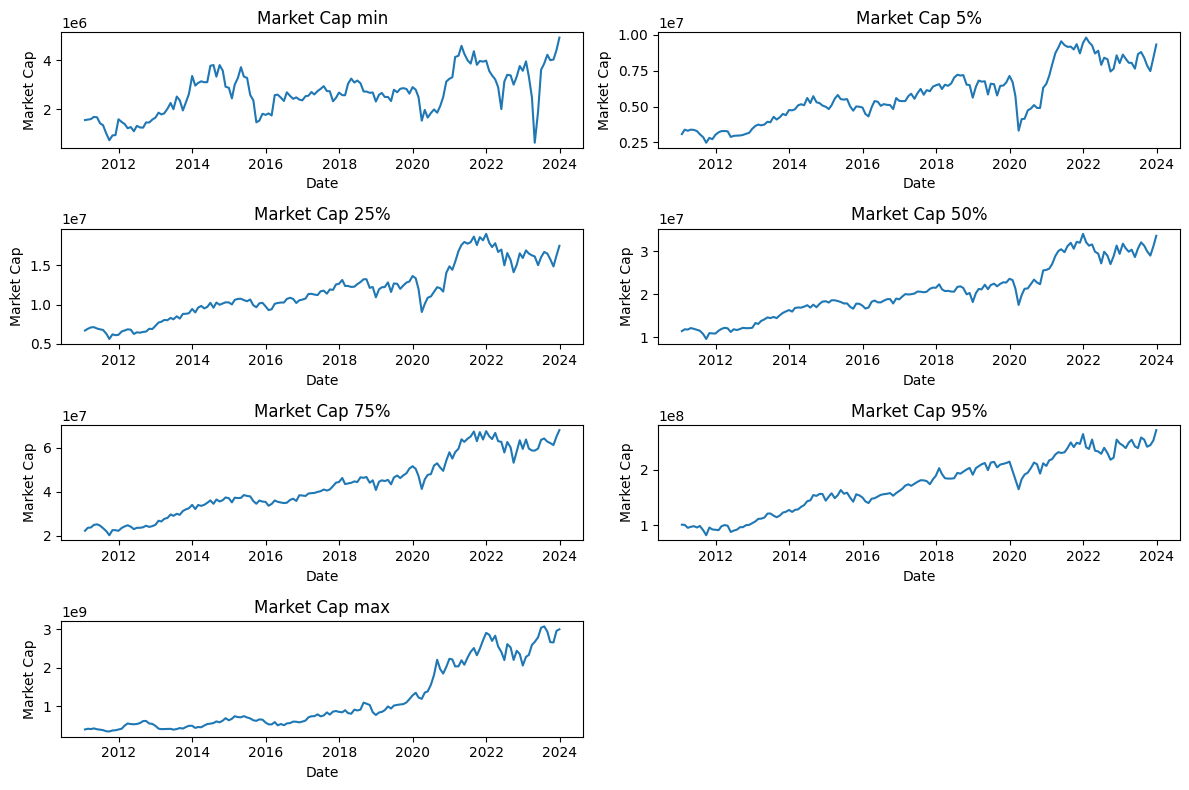

In [6]:
nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8))  

axes_flat = axes.flatten()

for i, col in enumerate(col_plot):
    # Filter the data for the current percentile
    data = mcap_plot[['date', col]].copy()
    data.rename(columns={col: 'mcap'}, inplace=True)
    
    # Plot on the i-th subplot in the flattened axes array
    sns.lineplot(ax=axes_flat[i], data=data, x='date', y='mcap')
    axes_flat[i].set_title(f'Market Cap {col}')
    axes_flat[i].set_ylabel('Market Cap')
    axes_flat[i].set_xlabel('Date')

if len(col_plot) % 2 != 0:
    axes_flat[-1].set_visible(False)

plt.tight_layout()
plt.show()


### Q5 a
Calculate the percentile range for the month prior stock leaving

In [7]:
percentiles=[0, 0.05,0.25,0.50, 0.75,0.95, 1]

last_dates = sp500_data.groupby('permno')['date'].max()
one_month_prior = last_dates - pd.DateOffset(months=1)

# Step 2: Convert 'one_month_prior' to a DataFrame for merging
one_month_prior_df = one_month_prior.reset_index()
one_month_prior_df.columns = ['permno', 'date']

prior_to_leaving = pd.merge(sp500_data, one_month_prior_df, how='inner', on=['permno', 'date'])
prior_to_leaving['date'] = prior_to_leaving['date'].dt.to_period('M')

# Calculate the quantiles of mcap for all companies on each date
prior_percentiles = prior_to_leaving.groupby('date')['mcap'].quantile(np.array(percentiles)).unstack()

# # Merge the permno information with the prior_percentiles DataFrame
# prior_percentiles = pd.merge(prior_percentiles, prior_to_leaving[['date', 'permno']], on='date')

prior_percentiles

,0.00,0.05,0.25,0.50,0.75,0.95,1.00
date,,,,,,,
2011-02,2075951.64,3.072294e+06,7.057662e+06,1.203937e+07,1.589526e+07,1.897997e+07,19751150.10
2011-09,1119252.00,1.452419e+06,2.785089e+06,4.450926e+06,6.116763e+06,7.449433e+06,7782600.00
2011-11,1803942.70,1.803943e+06,1.803943e+06,1.803943e+06,1.803943e+06,1.803943e+06,1803942.70
2012-02,26233301.16,2.623330e+07,2.623330e+07,2.623330e+07,2.623330e+07,2.623330e+07,26233301.16
2012-03,1212050.28,2.275960e+06,6.531599e+06,1.185115e+07,1.734458e+07,2.173933e+07,22838013.00
2012-04,3377462.40,3.860524e+06,5.792769e+06,8.208075e+06,1.062338e+07,1.255563e+07,13038687.68
2012-07,5268457.95,5.268458e+06,5.268458e+06,5.268458e+06,5.268458e+06,5.268458e+06,5268457.95
2012-11,2062613.50,2.062614e+06,2.062614e+06,2.062614e+06,2.062614e+06,2.062614e+06,2062613.50
2012-12,1647663.24,1.647663e+06,1.647663e+06,1.647663e+06,1.647663e+06,1.647663e+06,1647663.24


 ### Q5 b
Calculate the percentile range of market caps one month before stocks entering

In [8]:
first_dates = sp500_data.groupby('permno')['date'].min()
first_dates_df = first_dates.reset_index()
first_dates_df.columns = ['permno', 'date']

upon_entering = pd.merge(sp500_data, first_dates_df, how = 'inner', on = ['permno', 'date'])
upon_entering['date'] = upon_entering['date'].dt.to_period('M')

entering_percentiles = upon_entering.groupby('date')['mcap'].quantile(np.array(percentiles)).unstack()

entering_percentiles

,0.00,0.05,0.25,0.50,0.75,0.95,1.00
date,,,,,,,
2011-01,1.546778e+06,3.083643e+06,6.678938e+06,1.147552e+07,2.218710e+07,1.007589e+08,4.068335e+08
2011-02,1.020416e+07,1.020416e+07,1.020416e+07,1.020416e+07,1.020416e+07,1.020416e+07,1.020416e+07
2011-03,2.565047e+07,2.565047e+07,2.565047e+07,2.565047e+07,2.565047e+07,2.565047e+07,2.565047e+07
2011-04,8.302238e+06,8.463407e+06,9.108084e+06,9.913930e+06,1.791928e+07,2.432356e+07,2.592463e+07
2011-06,5.492196e+06,6.031846e+06,8.190446e+06,1.088870e+07,1.358694e+07,1.574554e+07,1.628519e+07
...,...,...,...,...,...,...,...
2023-06,7.814901e+07,7.814901e+07,7.814901e+07,7.814901e+07,7.814901e+07,7.814901e+07,7.814901e+07
2023-08,4.413831e+07,4.413831e+07,4.413831e+07,4.413831e+07,4.413831e+07,4.413831e+07,4.413831e+07
2023-09,5.968635e+07,6.050417e+07,6.377542e+07,6.786448e+07,7.195355e+07,7.522480e+07,7.604262e+07


### Q5 i-vi


In [9]:
df = sp500_data.copy()
df.set_index('date', inplace=True)
df = df.sort_values(['permno', 'date'])

def geometric_return(returns):
    return np.prod(1+returns) - 1

# (i)	Trailing twelve month return based on prc (we will refer to this PRC_Ret(T12))
df['PRC_Ret(T12)'] = df.groupby('permno')['prc'].transform(lambda x: x.rolling(12).apply(geometric_return, raw = True))
# (ii)	Trailing twelve month return based on prices (we will refer to this Prices_Ret(T12))
df['Prices_Ret(T12)'] = df.groupby('permno')['Price_Ret(T1)'].transform(lambda x: x.rolling(12).apply(geometric_return, raw = True))

# (iii)	Trailing twelve month return excluding the most recent trailing month based on prc. 
# In other words, this eleven months of return starting from 12 months ago excluding the most recent month (we will to this as PRC_Ret(T12M1))
df['PRC_Ret(T12M1)'] = df.groupby('permno')['prc'].transform(lambda x: x.shift(1).rolling(window=11).apply(geometric_return, raw = True))
# (iv)	Trailing twelve month return excluding the most recent trailing month based on prices. 
# In other words, this eleven months of return starting from 12 months ago excluding the most recent month (we will to this as Prices_Ret(T12M1))
df['Prices_Ret(T12M1)'] = df.groupby('permno')['Price_Ret(T1)'].transform(lambda x: x.shift(1).rolling(window=11).apply(geometric_return, raw = True))

# one-month-return from 12 months ago
# (v)	The trailing one month return from exactly 12 months ago. 
# In other words, if the EOM period is 2019-03 (March 2019), we want the return for the stock for 2018-03 (March 2018). 
# Do this based both on prc column and price based return. We will refer to this as PRC_Ret(T12_1M) and Prices_Ret(T12_1M)
df['PRC_Ret(T12_1M)'] = df.groupby('permno')['prc'].shift(12)
df['Prices_Ret(T12_1M)'] =  df.groupby('permno')['Price_Ret(T1)'].shift(12)

# standard deviation of the monthly price based returns
# (vi)	Calculate the standard deviation of the monthly price_based returns used in calculating Prices_Ret(T12M1); we call this Vol_Prices_Ret(T12M1)
df['Vol_Prices_Ret(T12M1)'] = df.groupby('permno')['Price_Ret(T1)'].transform(lambda x: x.shift(1).rolling(window=11).std())
# Divide Prices_Ret(T12M1) / Vol_Prices_Ret(T12M1). We will call this SR_Prices_Ret(T12M1)
df['SR_Prices_Ret(T12M1)'] = df['Prices_Ret(T12M1)'] / df['Vol_Prices_Ret(T12M1)']

df[df['permno'] == 13688].head(15)

,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1)
date,,,,,,,,,,,,,,
2011-01-31,13688,46.28,392066,-0.032609,18144814.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,13688,46.06,396258,-0.004754,18251643.48,-0.004754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-31,13688,44.18,396789,-0.030938,17530138.02,-0.040816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-29,13688,46.08,396789,0.043006,18284037.12,0.043006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-31,13688,43.38,397950,-0.058594,17263071.00,-0.058594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,13688,42.03,397950,-0.020632,16725838.50,-0.031120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-29,13688,41.43,397950,-0.014276,16487068.50,-0.014276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-31,13688,42.35,402245,0.022206,17035075.75,0.022206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,13688,42.30,402245,0.009563,17014963.50,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Calculate 1-month, 3-month, 6-month returns
df['PRC_Ret(F1M)'] = df.groupby('permno')['prc'].shift(-1)
df['PRC_Ret(F3M)'] = df.groupby('permno')['prc'].rolling(3).apply(geometric_return).groupby(level=0).shift(-3).reset_index(level=0, drop=True)
df['PRC_Ret(F6M)'] = df.groupby('permno')['prc'].rolling(6).apply(geometric_return).groupby(level=0).shift(-6).reset_index(level=0, drop=True)

df[df['permno'] == 13688].head(20)


,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1),PRC_Ret(F1M),PRC_Ret(F3M),PRC_Ret(F6M)
date,,,,,,,,,,,,,,,,,
2011-01-31,13688,46.28,392066,-0.032609,18144814.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004754,0.005932,-0.085788
2011-02-28,13688,46.06,396258,-0.004754,18251643.48,-0.004754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030938,-0.048486,-0.061023
2011-03-31,13688,44.18,396789,-0.030938,17530138.02,-0.040816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043006,-0.038366,-0.021779
2011-04-29,13688,46.08,396789,0.043006,18284037.12,0.043006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.058594,-0.091179,-0.048810
2011-05-31,13688,43.38,397950,-0.058594,17263071.00,-0.058594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.020632,-0.013176,-0.085230
2011-06-30,13688,42.03,397950,-0.020632,16725838.50,-0.031120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014276,0.017249,0.002219
2011-07-29,13688,41.43,397950,-0.014276,16487068.50,-0.014276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022206,0.046620,0.002921
2011-08-31,13688,42.35,402245,0.022206,17035075.75,0.022206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009563,-0.073016,0.005746
2011-09-30,13688,42.30,402245,0.009563,17014963.50,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014185,-0.014775,0.048444


In [11]:
df[df['permno'] == 13688].tail(20)

,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1),PRC_Ret(F1M),PRC_Ret(F3M),PRC_Ret(F6M)
date,,,,,,,,,,,,,,,,,
2018-08-31,13688,46.18,517151,0.071959,23882033.18,0.071959,-0.338740,-0.343848,-0.383129,-0.387894,0.039740,0.039740,0.073846,-5.252737,-0.003681,-0.428756,-0.354049
2018-09-28,13688,46.01,517151,-0.003681,23794117.51,-0.003681,-0.324276,-0.324277,-0.321780,-0.321780,-0.025007,-0.032538,0.081380,-3.954051,0.017388,-0.483808,-0.328537
2018-10-31,13688,46.81,517151,0.017388,24207838.31,0.017388,-0.189717,-0.189718,-0.203565,-0.203566,-0.151564,-0.151564,0.071131,-2.861863,-0.436445,-0.393997,-0.354625
2018-11-30,13688,26.38,518674,-0.436445,13682620.12,-0.436445,-0.513643,-0.513643,-0.136983,-0.136984,-0.061104,-0.061104,0.070312,-1.948229,-0.099697,0.130781,0.125019
2018-12-31,13688,23.75,518674,-0.099697,12318507.50,-0.099697,-0.470221,-0.470221,-0.411554,-0.411555,-0.173488,-0.173488,0.140641,-2.926289,0.194400,0.300800,0.293600
2022-10-31,13688,14.93,1987700,0.194400,29676361.00,-0.371368,-0.331439,-0.648126,-0.440254,-0.440255,-0.053536,-0.053536,0.141937,-3.101749,0.051574,0.064970,0.146015
2022-11-30,13688,15.70,1987700,0.051574,31206890.00,0.051574,-0.274032,-0.617912,-0.309637,-0.636651,-0.031581,-0.031581,0.173600,-3.667350,0.035669,-0.005095,0.078980
2022-12-30,13688,16.26,1987700,0.035669,32320002.00,0.035669,-0.296745,-0.629866,-0.320965,-0.642613,0.069117,0.069117,0.172270,-3.730258,-0.022140,-0.005535,0.062730
2023-01-31,13688,15.90,1987700,-0.022140,31604430.00,-0.022140,-0.344685,-0.655098,-0.329848,-0.647289,0.049397,0.049397,0.171354,-3.777486,-0.017610,0.076100,0.107546


# Q6

plot the time series of different variables

In [12]:
var_list = ['Price_Ret(T1)',
            'PRC_Ret(T12)', 'Prices_Ret(T12)', 
            'PRC_Ret(T12M1)', 'Prices_Ret(T12M1)', 
            'PRC_Ret(T12_1M)', 'Prices_Ret(T12_1M)',
            'Vol_Prices_Ret(T12M1)', 'SR_Prices_Ret(T12M1)', 
            'PRC_Ret(F1M)', 'PRC_Ret(F3M)', 'PRC_Ret(F6M)']

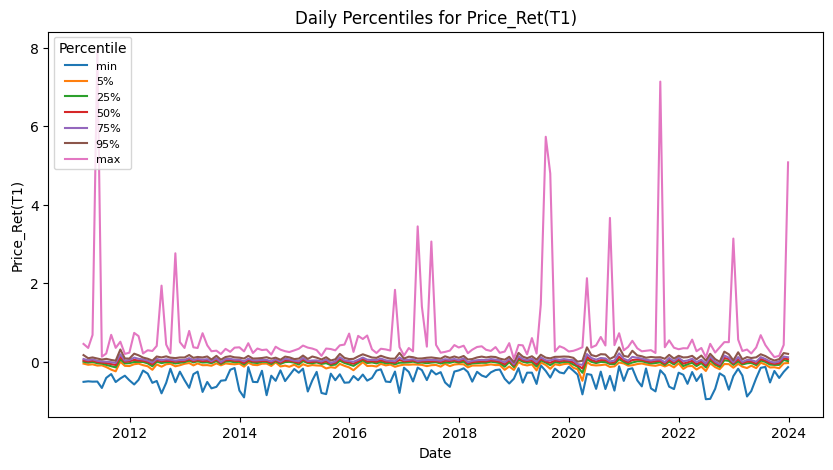

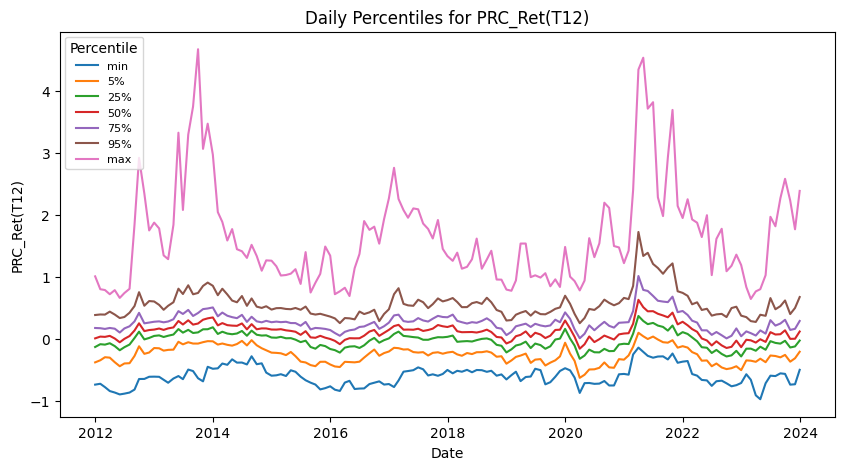

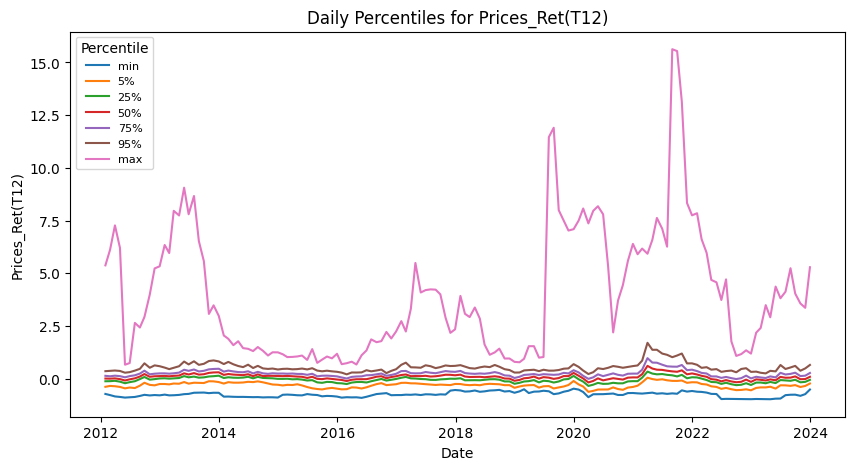

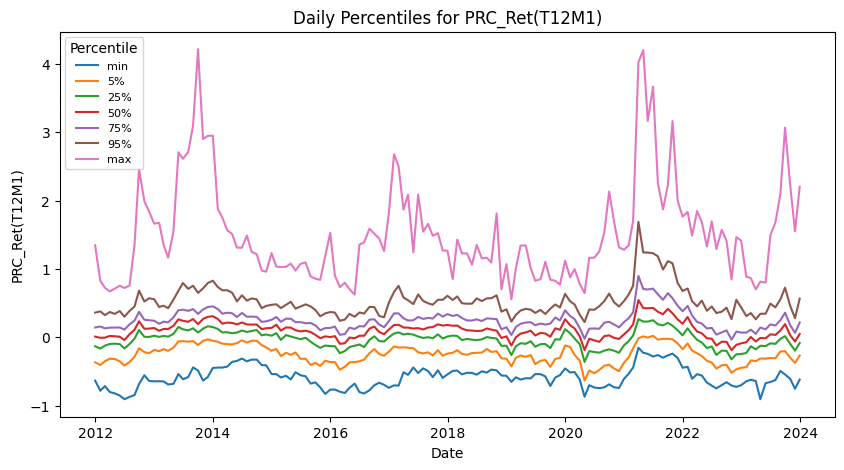

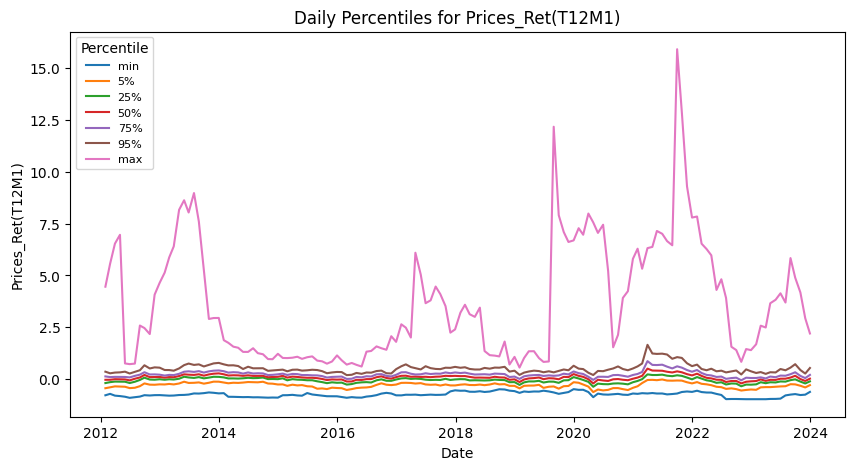

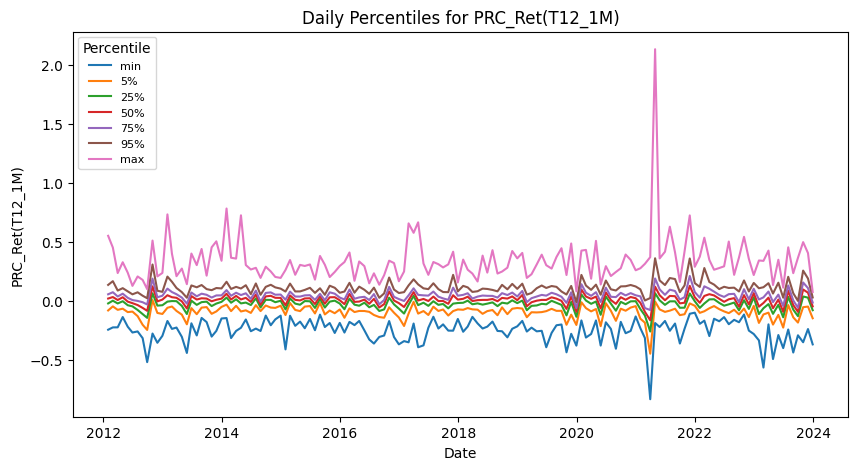

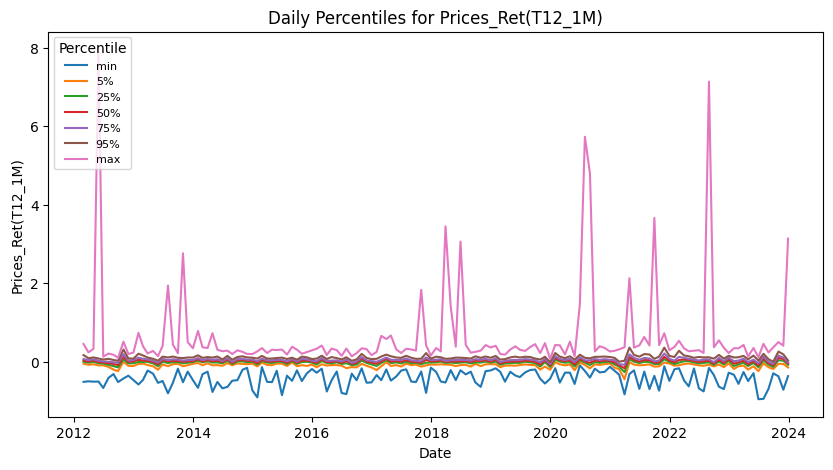

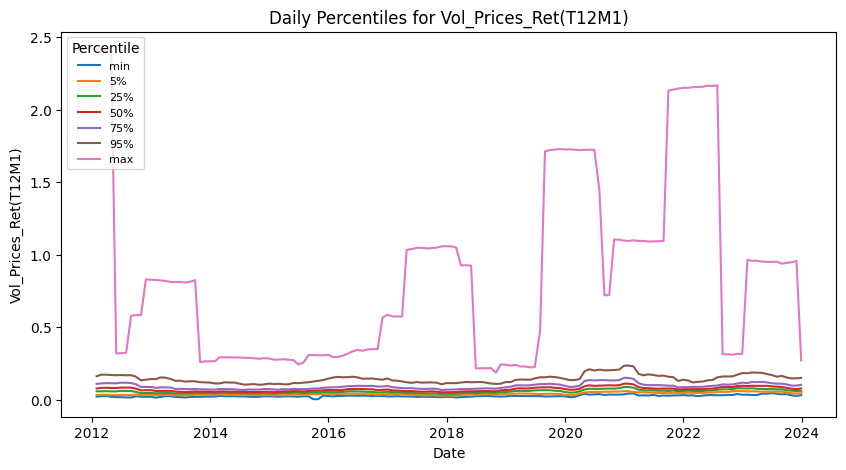

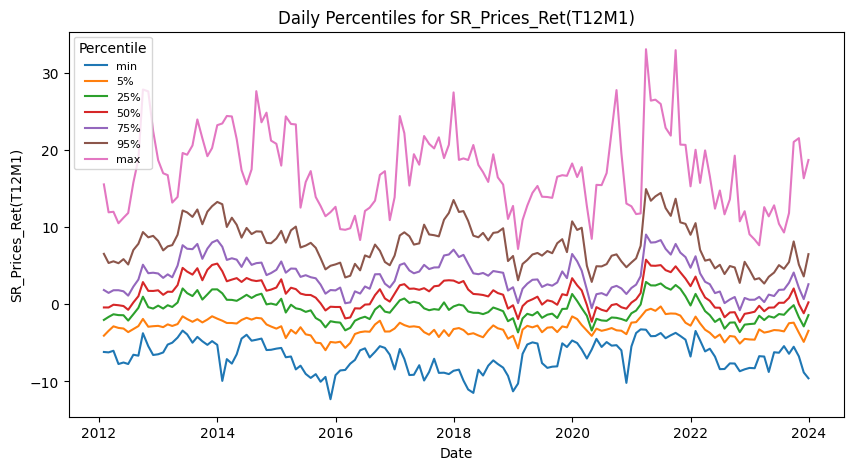

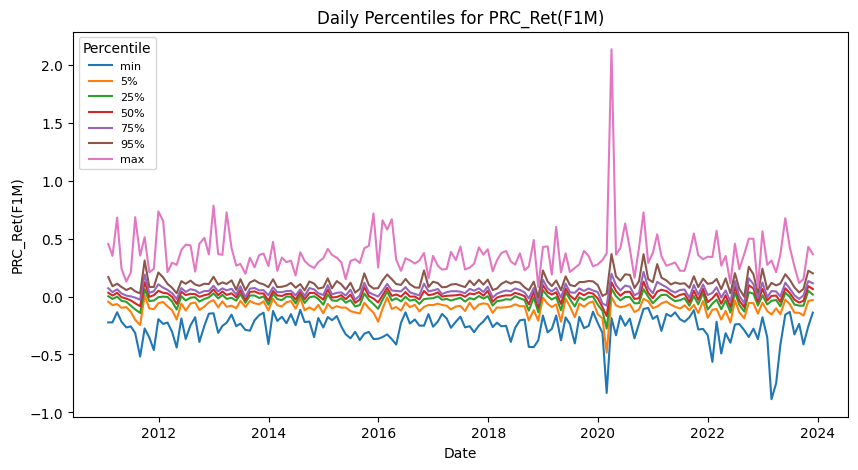

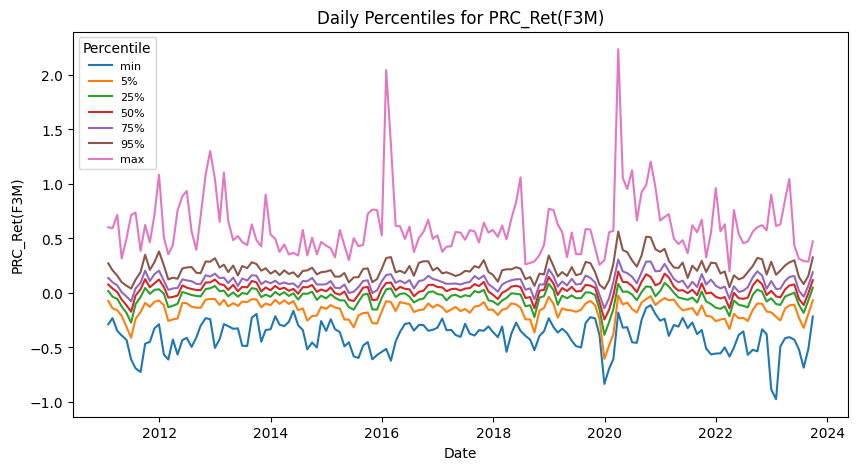

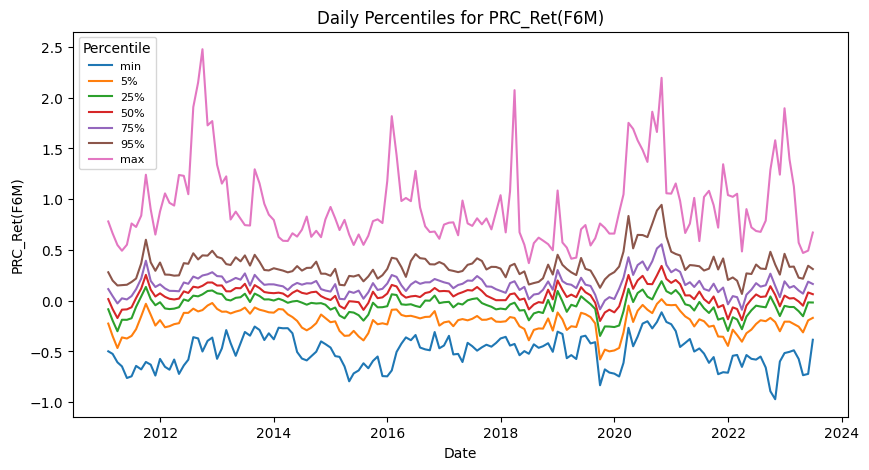


Price_Ret(T1):
  Median of the min percentile: -0.39167808645820357
  Median of the 5% percentile: -0.08980909941590991
  Median of the 25% percentile: -0.026080186843129516
  Median of the 50% percentile: 0.009840098400984099
  Median of the 75% percentile: 0.04500901155123471
  Median of the 95% percentile: 0.10878458921692565
  Median of the max percentile: 0.351092168353756

PRC_Ret(T12):
  Median of the min percentile: -0.6021358561790884
  Median of the 5% percentile: -0.2601085754336827
  Median of the 25% percentile: -0.029966241406540944
  Median of the 50% percentile: 0.11711134844528892
  Median of the 75% percentile: 0.2663292586916528
  Median of the 95% percentile: 0.5185331023066828
  Median of the max percentile: 1.4529489569958174

Prices_Ret(T12):
  Median of the min percentile: -0.7557145651081932
  Median of the 5% percentile: -0.30622521054976753
  Median of the 25% percentile: -0.05933295773842828
  Median of the 50% percentile: 0.08761902974020108
  Median of th

In [13]:
medians_dict = {}

for var in var_list:
    # Calculate percentiles
    percentiles_df = df.groupby('date')[var].describe(percentiles=[0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0]).reset_index()
    percentiles_df = percentiles_df[['date', 'min', '5%', '25%', '50%', '75%', '95%', 'max']]
    
    # Melt the dataframe
    melted_df = percentiles_df.melt(id_vars=['date'], var_name='Percentile', value_name=var)

    # Plotting
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=melted_df, x='date', y=var, hue='Percentile')
    plt.title(f'Daily Percentiles for {var}')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.legend(title='Percentile',  fontsize="8", loc ="upper left")
    plt.show()
    
    # Calculating median values for each percentile
    medians_dict[var] = {}
    for percentile in ['min', '5%', '25%', '50%', '75%', '95%', 'max']:
        # Filter the dataframe for the current percentile
        filtered_df = melted_df[melted_df['Percentile'] == percentile]
        # Calculate the median of these values
        median_value = filtered_df[var].median()
        medians_dict[var][percentile] = median_value

# Print median values for each percentile of each variable
for var, percentiles in medians_dict.items():
    print(f"\n{var}:")
    for percentile, median_value in percentiles.items():
        print(f"  Median of the {percentile} percentile: {median_value}")

### Q7 Fama-McBeth Cross-sectional Regression

#### a)

In [14]:
# Period: October 31st 2019 to November 30th 2019
# dependent var: PRC_Ret(F1M)
# independent variables: PRC_Ret(T12M1)

import statsmodels.api as sm

date = df.index[df.index <= '2019-11-30'].max()
print(date)
nov_2019_df = df.loc[date].copy()
nov_2019_df.dropna(inplace=True)

X = sm.add_constant(nov_2019_df['PRC_Ret(T12M1)'])
Y = nov_2019_df['PRC_Ret(F1M)']

print(nov_2019_df.shape)

model = sm.OLS(Y, X).fit()
print(model.summary())


2019-11-29 00:00:00
(472, 17)
                            OLS Regression Results                            
Dep. Variable:           PRC_Ret(F1M)   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     17.26
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           3.87e-05
Time:                        12:31:55   Log-Likelihood:                 749.89
No. Observations:                 472   AIC:                            -1496.
Df Residuals:                     470   BIC:                            -1487.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

Based on the OLS regression results of regression one-month forward returns (PRC_Ret(F1M)) on PRC_Ret(T12M1) for November 2019:


The intercept term (constant coefficient) is 0.0325, indicating that when PRC_Ret(T12M1) is 0, no momentum from the past 12 months excluding the most recent month, the expected one-month forward return is 3.25%. This is the average level of one-month forward returns when there's no momentum effect from the specified period.

The coefficient for PRC_Ret(T12M1) is -0.0441. This coefficient is statistically significant (p < 0.0001), as indicated by the very low p-value. The negative sign of the coefficient suggests that there's an inverse relationship between past 12-month returns, excluding the most recent month, and the one-month forward return. 

Thus, a 1% increase in PRC_Ret(T12M1) is associated with a 0.0441% decrease in the one-month forward return (PRC_Ret(F1M)).



#### b) Cross-sectinal regression

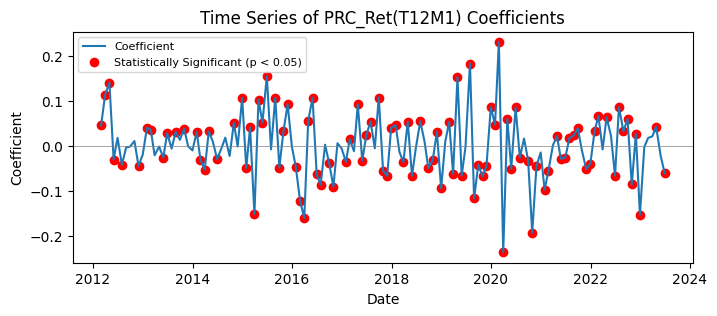

In [31]:
all_df = df.copy()
all_df.dropna(inplace=True)

dates = all_df.index.unique()
coefficients = []
p_values = []


for period in dates:
    period_data = all_df.loc[period].copy()
    
    X = sm.add_constant(period_data['PRC_Ret(T12M1)'])
    Y = period_data['PRC_Ret(F1M)']
        
    model = sm.OLS(Y, X).fit()
    coefficients.append(model.params['PRC_Ret(T12M1)'])
    p_values.append(model.pvalues['PRC_Ret(T12M1)'])

results_df = pd.DataFrame({'Date': dates, 'Coefficient': coefficients, 'P-Value': p_values})

plt.figure(figsize=(8, 3))
plt.plot(results_df['Date'], results_df['Coefficient'], label='Coefficient')
plt.axhline(0, color='grey', lw=0.5) 
plt.title('Time Series of PRC_Ret(T12M1) Coefficients')
plt.xlabel('Date')
plt.ylabel('Coefficient')

significant_periods = results_df[results_df['P-Value'] < 0.05]
plt.scatter(significant_periods['Date'], significant_periods['Coefficient'], color='red', label='Statistically Significant (p < 0.05)')

plt.legend(fontsize="8", loc ="upper left")
plt.show()


In [32]:
print(results_df[-50:-30])

          Date  Coefficient       P-Value
87  2019-05-31    -0.066186  1.114739e-06
88  2019-06-28    -0.002442  8.357974e-01
89  2019-07-31     0.182823  3.191481e-26
90  2019-08-30    -0.116525  3.013890e-22
91  2019-09-30    -0.041888  7.642035e-04
92  2019-10-31    -0.067680  3.123300e-08
93  2019-11-29    -0.044127  3.870269e-05
94  2019-12-31     0.085879  1.214144e-08
95  2020-01-31     0.046980  1.047135e-03
96  2020-02-28     0.230302  8.366097e-13
97  2020-03-31    -0.236381  3.585846e-12
98  2020-04-30     0.059752  2.808616e-05
99  2020-05-29    -0.050550  6.144411e-05
100 2020-06-30     0.085291  1.962104e-09
101 2020-07-31    -0.026146  4.729591e-02
102 2020-08-31     0.016214  8.480634e-02
103 2020-09-30    -0.032552  1.437561e-03
104 2020-10-30    -0.192795  7.784050e-32
105 2020-11-30    -0.045280  4.612879e-06
106 2020-12-31    -0.014737  2.237001e-01


The t-statistic for PRC_Ret(T12M1) is -4.155, with a p-value < 0.0001, providing strong evidence against the null hypothesis, and indicating that PRC_Ret(T12M1) is a significant predictor of PRC_Ret(F1M).

The R-squared value is 0.035, meaning that about 3.5% of the variability in the one-month forward returns can be explained by the past 12-month returns excluding the most recent month. Although the model is statistically significant, the R-squared value suggests that the model explains a relatively small portion of the variance in forward returns.

Economic Interpretation
Economically, the negative coefficient for PRC_Ret(T12M1) suggests that a momentum strategy based on the past 12 months excluding the most recent month may not be effective over this specific period; in fact, it might indicate a reversal effect, where stocks that performed well over the past year excluding the most recent month tend to perform slightly worse in the following month.

Explaining to a Layperson
The analysis of stock returns shows that looking at how well stocks did in the past year doesn't help us predict next month's winners. In fact, stocks that rose the most last year tended to do slightly worse the following month. This suggests that picking stocks based solely on their past momentum might not be a reliable strategy, at least over the period in this analysis.

Conclusion
The results indicate a statistically significant inverse relationship between past returns and future returns for the period analyzed. However, the low R-squared value suggests that PRC_Ret(T12M1) alone does not strongly predict future returns, and other factors not included in this model may also influence future returns. These findings highlight the complexity of financial markets and the difficulty in predicting stock returns based on past performance alone.

The time series plot of coefficients over the entire sample period reveals fluctuations in the predictive power of PRC_Ret(T12M1) over time. 

There are periods where the coefficient is significantly positive, indicating periods where momentum strategies (buying past winners and selling past losers) would have performed well. Conversely, there are also periods with significantly negative coefficients, indicating short-term reversals where momentum strategies would underperform.

The presence of both significantly positive and negative coefficients over the sample indicates that the effectiveness of a momentum strategy can vary greatly over time. This variation could be influenced by market conditions, investor sentiment, economic factors, or other variables not captured by the model.

Economic and Statistical Interpretation
Economically, this analysis suggests that momentum investing is not universally effective across all periods. The strategy's effectiveness depends on the market environment, with some periods showing that past winners continue to outperform (momentum) and other periods indicating that past winners underperform (reversal).

Statistically, the variation in the significance and direction of the coefficient across different periods suggests that momentum's effectiveness is not stable over time. This instability makes it challenging to apply a one-size-fits-all momentum strategy across all market conditions.

Conclusion and Explanation to a Layperson
Momentum investing, which involves buying stocks that have performed well in the past and selling those that have performed poorly, doesn't always work. Our analysis shows that sometimes, stocks that did well in the past year don't continue to do so in the following month. This pattern changes over time; in some months, momentum investing might work, while in others, it might not.

Imagine surfing: catching a wave (or investing in a stock) at the right time can lead to a great ride (return), but conditions change, and not every wave is perfect. Sometimes, what seemed like a promising wave (a past winner) might suddenly lose its momentum, leading to a less successful ride. Therefore, relying solely on past performance is like trying to predict the ocean's behavior by looking at yesterday's waves.

Observations Across Time
2020-02-28     0.230302 
2020-03-31    -0.236381

There is a abrupt shift of the coefficient from 0.23 to -0.23 for 2020-02 and 2020-03, which corresponds to the melt down at the beginning of the COVID. This abrupt shift of coefficient may be due to that all stocks are suffering from a huge downturn in that period.

Significant periods, such as those with particularly high positive or negative coefficients, highlight times when momentum strategies either performed exceptionally well or poorly. These standout periods could be associated with specific market events or economic conditions that influenced investor behavior and market dynamics.

In conclusion, while momentum strategies can be part of an investor's toolkit, their application requires careful consideration of current and historical market conditions. There's no guarantee that past winners will continue their streak, and as seen, the strategy's effectiveness can change significantly over time.

#### d)

hit rates: 
Sortino reatio. This metric adjusts returns for downside risks. It is modified from sharpe ratio by using downside deviation instead of standard deviation to measure risk. It becomes more practical when investors are more concerned about potential losses than overall volatility.

In [33]:
all_df.describe()

,permno,price,shrout,prc,mcap,Price_Ret(T1),PRC_Ret(T12),Prices_Ret(T12),PRC_Ret(T12M1),Prices_Ret(T12M1),PRC_Ret(T12_1M),Prices_Ret(T12_1M),Vol_Prices_Ret(T12M1),SR_Prices_Ret(T12M1),PRC_Ret(F1M),PRC_Ret(F3M),PRC_Ret(F6M)
count,64555.000000,64555.000000,6.455500e+04,64555.000000,6.455500e+04,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000,64555.000000
mean,55484.229277,114.063349,6.302194e+05,0.011389,4.944994e+07,0.009318,0.137053,0.109618,0.124722,0.099791,0.010824,0.008812,0.079170,1.788010,0.011327,0.031975,0.065114
std,28833.326109,203.599752,1.120576e+06,0.083077,1.122484e+08,0.100292,0.308243,0.395039,0.290906,0.371272,0.081308,0.102972,0.063716,3.961284,0.083187,0.138063,0.201642
min,10104.000000,2.050000,3.196000e+03,-0.832263,1.089831e+06,-0.955823,-0.898914,-0.974808,-0.905043,-0.971920,-0.832263,-0.955823,0.014040,-12.302007,-0.832263,-0.835167,-0.970718
25%,24205.000000,42.190000,1.640870e+05,-0.034227,1.157675e+07,-0.036367,-0.046561,-0.081064,-0.046257,-0.077703,-0.033177,-0.035356,0.051147,-1.039211,-0.034320,-0.046490,-0.052624
50%,60628.000000,70.530000,3.102350e+05,0.012217,2.125028e+07,0.010157,0.117545,0.085291,0.107443,0.078568,0.012047,0.009986,0.068588,1.210705,0.012218,0.031697,0.060393
75%,82775.000000,120.200000,5.995445e+05,0.056143,4.514407e+07,0.054233,0.287099,0.256062,0.266871,0.239402,0.054664,0.052729,0.092550,4.004333,0.056037,0.108559,0.172034
max,93436.000000,6350.620120,1.710254e+07,2.135168,3.035217e+09,7.139768,4.679823,15.626183,4.215091,15.919743,2.135168,7.965142,2.411869,33.028226,2.135168,2.235839,2.476854


### 8 a) univariate regressions

#### Price_Ret(T1); PRC; PRC_Ret(T12); Prices_Ret(T12); PRC_Ret(T12M1); Prices_Ret(T12M1); PRC_Ret(T12_1M); Prices_Ret(T12_1M); and SR_Prices_Ret(T12M1)

In [34]:
def cross_sectional_regression(df, independent_var, dependent_var):
    dates = df.index.unique()
    coefficients = []
    p_values = []

    for period in dates:
        period_data = df.loc[period]
        
        X = sm.add_constant(period_data[independent_var])
        Y = period_data[dependent_var]
            
        model = sm.OLS(Y, X).fit()
        coefficients.append(model.params[independent_var])
        p_values.append(model.pvalues[independent_var])

    results_df = pd.DataFrame({'Date': dates, 'Coefficient': coefficients, 'P-Value': p_values})

    plt.figure(figsize=(8, 3))
    plt.plot(results_df['Date'], results_df['Coefficient'], label='Coefficient')
    plt.axhline(0, color='grey', lw=0.5) 
    plt.title(f'Time Series of {independent_var} Coefficients')
    plt.xlabel('Date')
    plt.ylabel('Coefficient')

    significant_periods = results_df[results_df['P-Value'] < 0.05]
    plt.scatter(significant_periods['Date'], significant_periods['Coefficient'], color='red', label='Statistically Significant (p < 0.05)')

    plt.legend(fontsize="8", loc ="upper left")
    plt.tight_layout()
    plt.show()

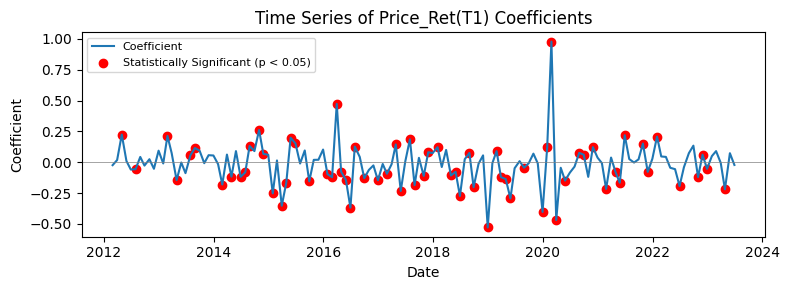

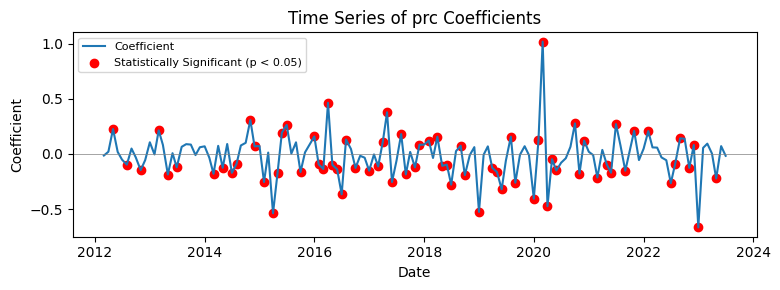

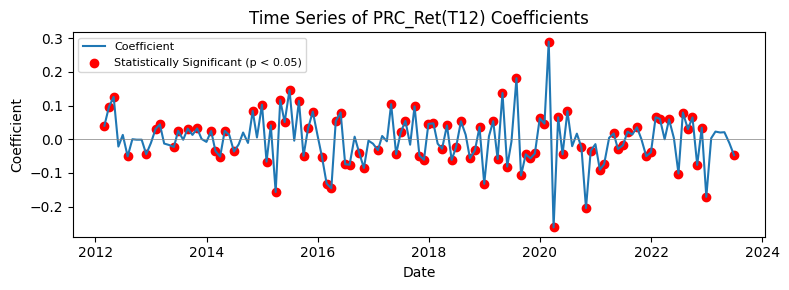

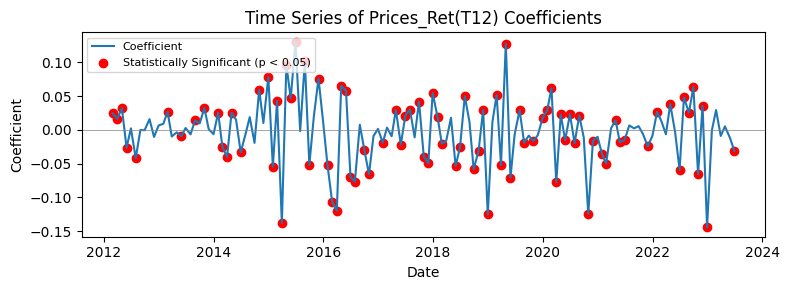

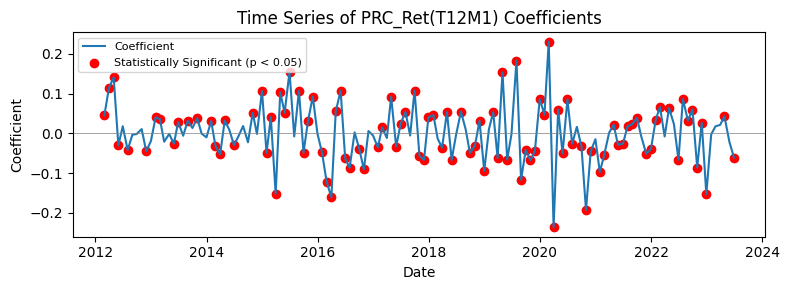

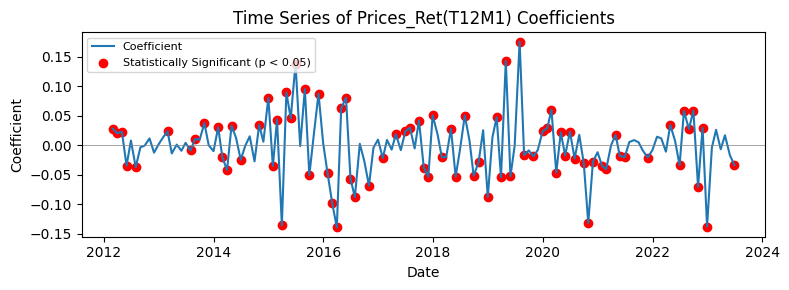

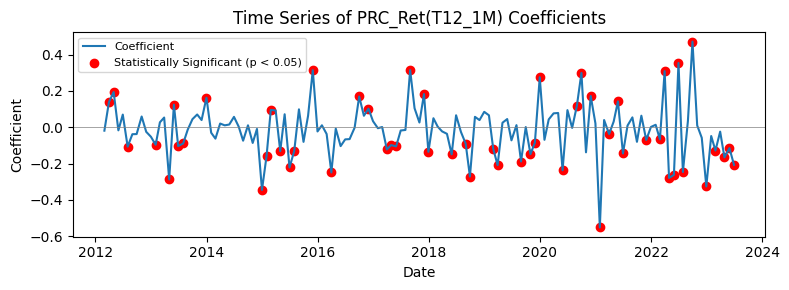

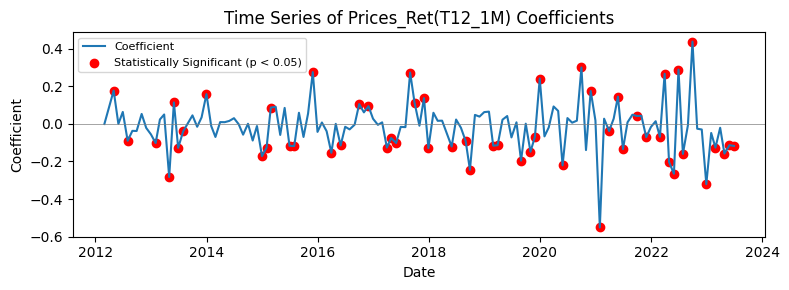

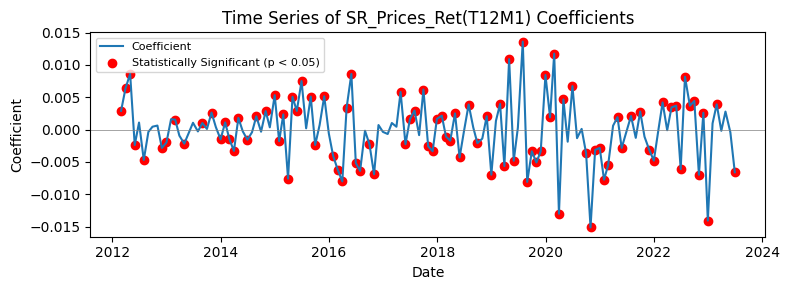

In [35]:
cross_sectional_regression(all_df, 'Price_Ret(T1)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'prc', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'PRC_Ret(T12)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'Prices_Ret(T12)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'PRC_Ret(T12M1)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'Prices_Ret(T12M1)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'PRC_Ret(T12_1M)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'Prices_Ret(T12_1M)', 'PRC_Ret(F1M)')
cross_sectional_regression(all_df, 'SR_Prices_Ret(T12M1)', 'PRC_Ret(F1M)')

Economically, I would not expect the sign of all the variables to be the same.


Survivorship Bias: Only including stocks that have survived through the entire period may bias the results.

Serial Correlation: Financial time series data often exhibit serial correlation, potentially inflating the significance of predictors.

#### 8 b) Multivariate Regression:
i.	Price_Ret(T1) and Prices_Ret(T12M1)

ii.	PRC and PRC_Ret(T12M1)

iii. PRC and Prices_Ret(T12)

iv.	PRC and SR_Prices_Ret(T12M1)


In [36]:
def multivariate_cross_sectional_regression(df, independent_var_list, dependent_var):
    dates = df.index.unique()
    results = []

    for period in dates:
        period_data = df.loc[period]
        
        X = sm.add_constant(period_data[independent_var_list])
        Y = period_data[dependent_var]
            
        model = sm.OLS(Y, X).fit()
        for var in independent_var_list:
            results.append({
                'Date' : period,
                'Variable' : var,
                'Coefficient' : model.params.get(var, 0),
                'p-value' : model.pvalues.get(var, 1)
            })

    results_df = pd.DataFrame(results)

    fig, axs = plt.subplots(1, len(independent_var_list), figsize=(16, 3))
    
    for i, var in enumerate(independent_var_list):
        var_data = results_df[results_df['Variable'] == var]
        axs[i].plot(var_data['Date'], var_data['Coefficient'], label='Coefficient')
        axs[i].axhline(0, color='grey', lw=0.5)
        axs[i].set_title(f'Time Series of {var} Coefficients')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Coefficient')
        
        significant_periods = var_data[var_data['p-value'] < 0.05]
        axs[i].scatter(significant_periods['Date'], significant_periods['Coefficient'], color='red', label='Statistically Significant (p < 0.05)')
        
        axs[i].legend()
    
    plt.tight_layout()
    plt.show()

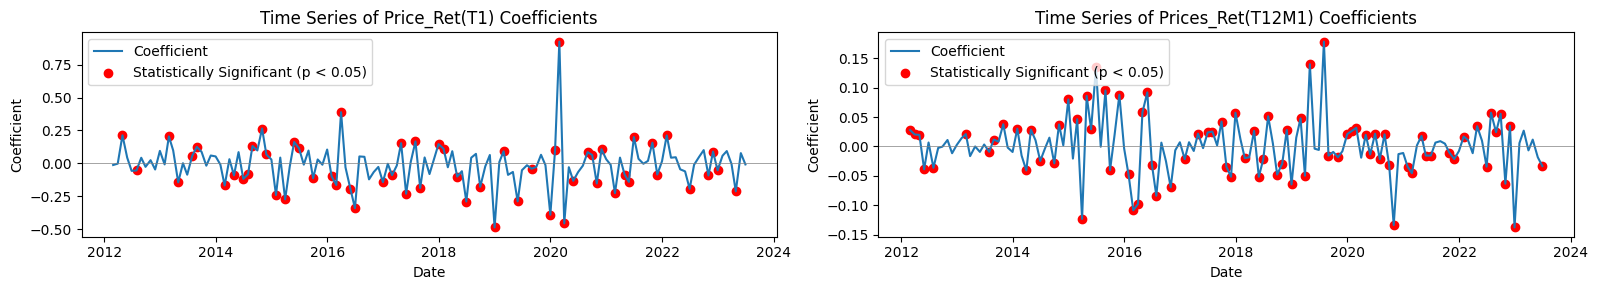

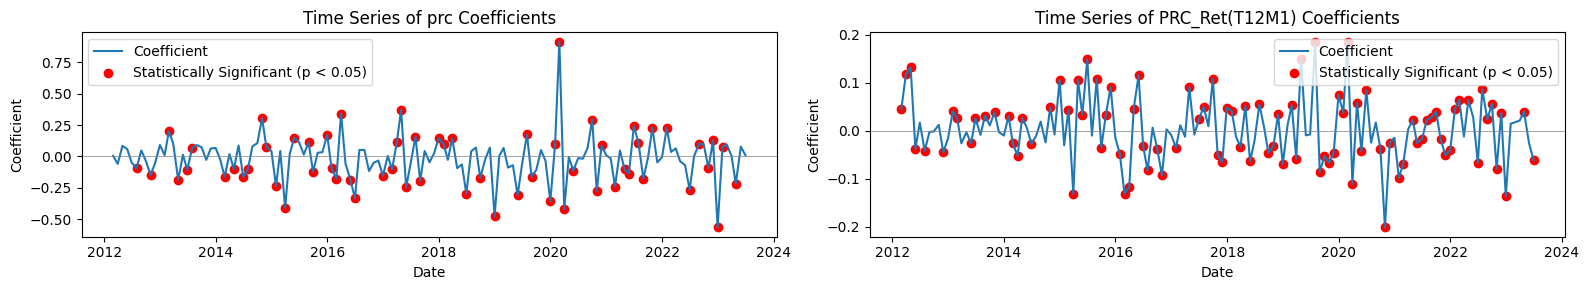

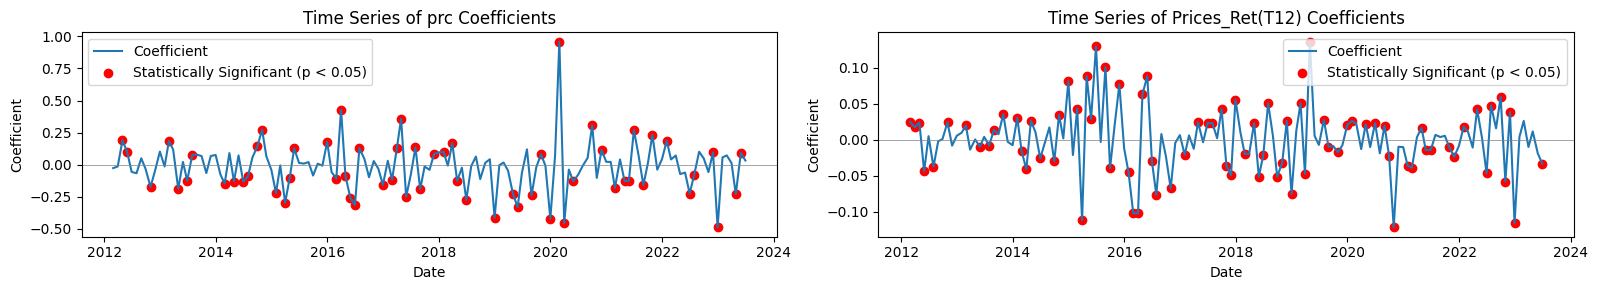

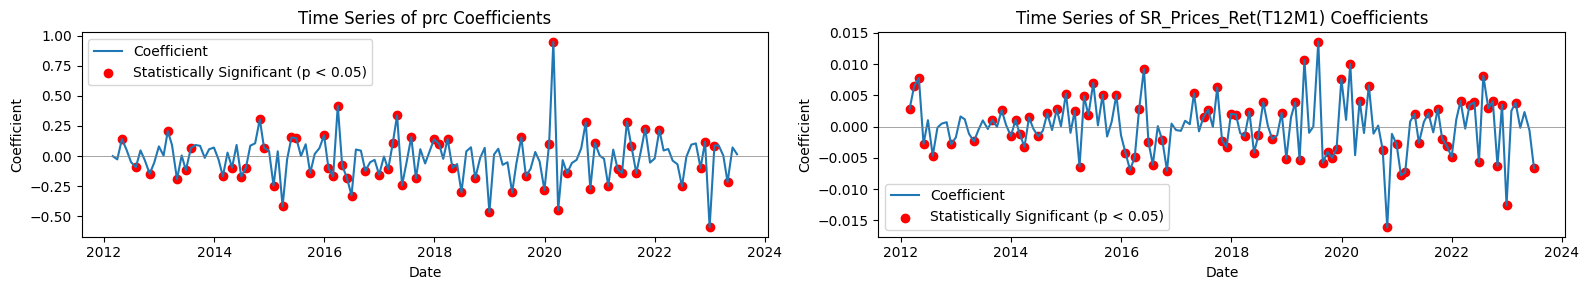

In [37]:
multivariate_cross_sectional_regression(all_df, ['Price_Ret(T1)', 'Prices_Ret(T12M1)'], 'PRC_Ret(F1M)')

multivariate_cross_sectional_regression(all_df, ['prc', 'PRC_Ret(T12M1)'], 'PRC_Ret(F1M)')

multivariate_cross_sectional_regression(all_df, ['prc', 'Prices_Ret(T12)'], 'PRC_Ret(F1M)')

multivariate_cross_sectional_regression(all_df, ['prc', 'SR_Prices_Ret(T12M1)'], 'PRC_Ret(F1M)')

Multicollinearity: High correlation among independent variables can distort the estimation of their coefficients and standard errors.
Model Specification: Incorrect model specification, omitting relevant variables or including irrelevant ones, can lead to biased estimates.
Variable Scaling: Differences in the scale of variables can affect their estimated impact, necessitating standardization or normalization in some cases.


Economic Interpretation and Results Reporting
After running these regressions, reporting should include:

Coefficients and their significance: Indicate the direction and strength of the relationship between each independent variable and future returns.
R-squared values: Show the proportion of variance in the dependent variable that's predictable from the independent variables.
Diagnostic Statistics: Address potential issues such as heteroskedasticity, autocorrelation, and multicollinearity.
Economic Discussion:

Discuss the plausibility of the signs and magnitudes of the coefficients in the context of financial theory and market behavior.
Reflect on any anomalies or unexpected results, considering aspects like market efficiency, behavioral finance insights, or data peculiarities.
Comment on the practical implications of your findings for investors or portfolio managers, including any strategies that could be informed by the regression outcomes.
Conclusion
The Fama-McBeth regression approach provides a robust framework for examining the relationship between various financial metrics and future returns. While the methodology is powerful, careful consideration of economic theory, data integrity, and statistical issues is crucial for deriving valid and insightful conclusions.

### 9 Cross-sectional regression:
independent variables is PRC_Ret(T12M1)

dependent variables: PRC_Ret(F3M) and PRC_Ret(F6M). 

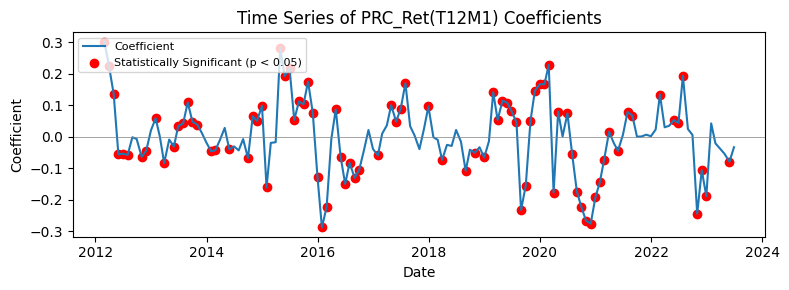

In [38]:
cross_sectional_regression(all_df, 'PRC_Ret(T12M1)', 'PRC_Ret(F3M)')

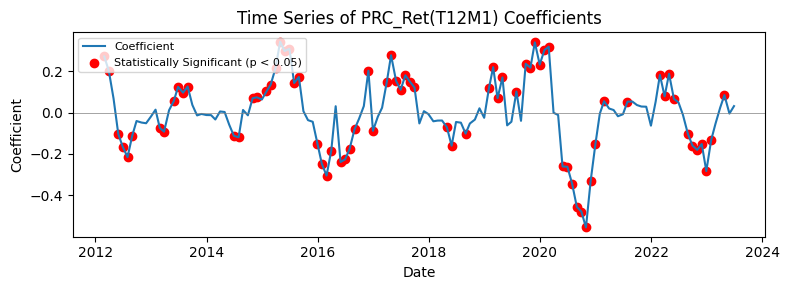

In [39]:
cross_sectional_regression(all_df, 'PRC_Ret(T12M1)', 'PRC_Ret(F6M)')

Coefficient Fluctuations: The coefficients over time fluctuate around zero, which suggests that the predictive power of PRC_Ret(T12M1) on future returns varies over time and may not be consistent.

Statistical Significance: In both plots, red dots signify statistically significant coefficients at the 5% level. There appear to be many more statistically significant points for the F1M forward returns compared to F3M and F6M. This indicates that as the forward-looking period increases, the predictive power of PRC_Ret(T12M1) diminishes.

Trend in Significance: The trend of the coefficients does not seem to follow a clear pattern, which could suggest that the relationship between past returns and future returns is not stable over time and may be influenced by market conditions, behavioral factors, or other external variables.



Given the observed reduction in statistically significant coefficients as the forward return period increases, we can deduce that momentum signals, specifically PRC_Ret(T12M1), are less predictive for longer-term returns. This might be explained by:

Market Efficiency: Markets may incorporate information more fully over longer periods, diluting the momentum effect.
Mean Reversion: Over longer periods, there's a higher chance for mean reversion, where stocks that performed well in the past may underperform as they revert to their long-term average.
Potential Econometric/Statistical Issues:
Non-Stationarity: Financial time series data may be non-stationary, particularly over different time horizons, which can affect the reliability of regression coefficients.
Serial Correlation: The presence of serial correlation in financial returns can lead to misestimation of the significance levels of the coefficients.
Changing Risk Premia: The risk-return tradeoff may change over time, which means the factors driving returns in one period might not be the same in another.
Correcting Issues:
Addressing Non-Stationarity: Use techniques like differencing, detrending, or transforming the series into stationary through logarithmic or percentage change transformations.
Accounting for Serial Correlation: Employ models that specifically adjust for time-series correlation, like the Generalized Method of Moments (GMM) or Newey-West standard errors.
Modeling Changing Risk Premia: Introduce additional variables to the regression that can account for changes in risk premia over time, or use rolling regression windows to capture the evolving relationships.
Conclusion:
The Fama-McBeth regression results, particularly the decrease in statistically significant coefficients for longer forward returns, suggest that the momentum effect identified by PRC_Ret(T12M1) diminishes over longer periods. This is in line with the economic theory of market efficiency and mean reversion over time. The reliability of these regression results can be improved by addressing the potential econometric and statistical issues mentioned, thus yielding more robust insights into the predictive power of momentum signals across different investment horizons.

#### 10

Understanding of Momentum Signals
Foundation in Quantitative Analysis: The homework solidifies the fundamental concept of momentum in finance—that past returns can influence future performance. It's a deep dive into how quantitative researchers can identify and leverage historical data patterns to predict future market movements.
Signal Creation and Testing: Learning how to create various momentum signals from raw data teaches the practical aspects of data handling, signal processing, and the nuances of different financial metrics. It’s crucial for developing any systematic trading strategy.
Econometric Skills
Cross-sectional Regression Analysis: Performing Fama-McBeth regressions is a core skill in asset pricing studies. It teaches you how to explore the relationships between return predictors and actual returns across different assets at a given time, a method widely used in academic research and industry analysis.
Understanding Statistical Significance: Through this exercise, you learn to critically evaluate the statistical significance of your findings, understanding not just when a signal appears to predict returns, but also gauging the reliability of these predictions.
Investment Strategy Insights
Efficacy of Momentum Strategies: By analyzing momentum [-12, -1] or any other specified periods, you gain insights into the effectiveness of momentum-based investment strategies. It helps quantify how past performance can be indicative (or not) of future returns, a cornerstone of many quantitative trading strategies.
Diverse Time Horizons: Comparing short-term (F1M) with medium (F3M) and long-term (F6M) forward returns highlights how the predictive power of signals can vary over different investment horizons. This can inform the development of strategies tailored to specific time frames.
Econometric/Statistical Challenges
Identifying Issues: Recognizing potential econometric or statistical issues, such as autocorrelation or multicollinearity, in your regression analysis teaches critical problem-solving skills. It’s about not just running models but understanding and addressing their limitations.
Improving Model Accuracy: The homework pushes you to think about how to correct identified issues, whether through model refinement, variable transformation, or alternative estimation techniques. This iterative process is key to refining investment strategies.
Broader Implications
Critical Thinking: Beyond technical skills, this homework encourages critical thinking about what drives stock market returns and how different variables might interact with each other. It’s a practical exercise in hypothesis testing and theory application.
Innovation in Strategy Development: Finally, this exercise underlines the importance of innovation and continuous learning in developing investment strategies. The financial markets are ever-changing, and strategies that worked in the past may not work in the future. Hence, a quantitative researcher must always be testing, learning, and adapting.
In summary, this homework is a comprehensive exercise in applying quantitative finance principles to real-world data, teaching you not just about the specific topic of momentum but also about the broader skills and challenges involved in developing and testing investment strategies. It underscores the importance of a rigorous, data-driven approach to understanding market dynamics and highlights the complexities and nuances of predictive modeling in finance.